# Galaxy classification using CNNs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

import warnings
warnings.filterwarnings("ignore")

Get data and show example of breakdown of answers for a galaxy

In [2]:
gz5_path = 'C:/Users/mbeye/Downloads/gz_decals_volunteers_5.csv'
gz5_data = pd.read_csv(gz5_path)
gz5_data.columns = gz5_data.columns.str.replace('-', '_').str.replace(' ', '_')
print(gz5_data.head(3).T.to_string())

                                                                             0                                 1                                 2
iauname                                                    J112953.88-000427.4               J104325.29+190335.0               J104629.54+115415.1
ra                                                                  172.474526                        160.856533                        161.623135
dec                                                                  -0.074281                         19.060441                         11.904197
redshift                                                              0.124142                          0.049088                          0.092906
elpetro_absmag_r                                                    -21.253342                         -21.77541                        -19.947397
sersic_nmgy_r                                                        167.26288                         2941.7292      

In [3]:
len(gz5_data)

253286

Checking distribution of number of total classification votes for a galaxy

Total number of samples with more than 30 votes:  59185


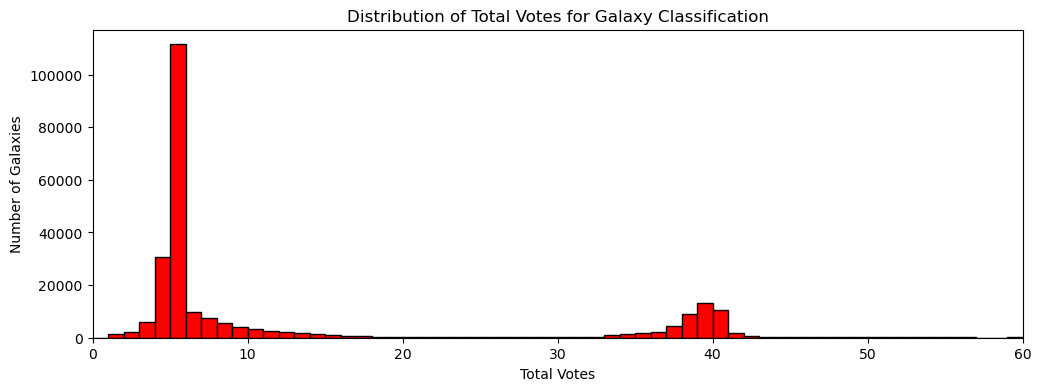

In [4]:
print("Total number of samples with more than 30 votes: ", len(gz5_data[gz5_data['smooth_or_featured_total_votes'] > 30]))

# Plotting the distribution of total votes for galaxy classification
plt.figure(figsize=(12, 4))
plt.hist(gz5_data['smooth_or_featured_total_votes'], bins=60, range=(0, 60), edgecolor='k', color='r')
plt.title('Distribution of Total Votes for Galaxy Classification')
plt.xlabel('Total Votes')
plt.ylabel('Number of Galaxies')
plt.xlim(0, 60)
plt.show()

Reads through all files in the designated directory, and checks that it is found in the GZD-5 data, and then stores the name in ```image_filenames``` if it matches the given conditions (Number of votes > 30 and that ```wrong_size_warning == False```)

In [5]:
validation_galaxies = pd.read_csv('validation_galaxies.csv')
print("Number of validation galaxies:", len(validation_galaxies))

Number of validation galaxies: 3758


In [6]:
data_folder_path = 'C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1'

image_filenames = []
image_filepaths = []

n_files_found = 0

# Create a dictionary to hold gz5 data for quick lookup
gz5_dict = {}
for row in gz5_data.itertuples(index=False):
    if row.iauname and row.smooth_or_featured_total_votes >= 30: #and not row.wrong_size_warning:
        gz5_dict[row.iauname] = row

# Walk through the directory and find matching .png files by comparing to dictionary
for root, dirs, files in os.walk(data_folder_path):
    for file in files:
        n_files_found += 1
        if file.lower().endswith('.png'):
            base_name = os.path.splitext(file)[0]
            if base_name in gz5_dict:
                image_filenames.append(base_name)
                image_filepaths.append(os.path.join(root, file))

print("Total .png files found:", n_files_found)
print("Total matching images:", len(image_filenames))


Total .png files found: 91481
Total matching images: 18869


Let's try to simplify the labels a little bit more 

In [7]:
gz5_data_reduced = gz5_data[gz5_data['iauname'].isin(image_filenames)].copy().sort_values(by='iauname').reset_index(drop=True)
gz5_data_reduced

,iauname,ra,dec,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,petro_th90,petro_theta,upload_group,...,merging_minor_disturbance_fraction,merging_minor_disturbance_debiased,merging_major_disturbance,merging_major_disturbance_fraction,merging_major_disturbance_debiased,merging_merger,merging_merger_fraction,merging_merger_debiased,wrong_size_statistic,wrong_size_warning
0,J000007.82-000226.0,0.032593,-0.040570,0.023664,-19.440268,1073.512600,4.269538,12.730249,9.522999,pre_active,...,0.178571,0.174051,2,0.035714,0.038462,1,0.017857,0.019459,123.138082,False
1,J000012.78+010712.7,0.053264,1.120225,0.024673,-20.407923,2615.325700,10.394143,21.012920,20.303660,pre_active,...,0.283019,0.281042,6,0.113208,0.120000,2,0.037736,0.040431,140.170549,False
2,J000127.32+141126.9,0.363885,14.190809,0.095513,-20.495888,173.504290,2.621211,8.270784,5.730439,active_priority,...,0.177778,0.197576,0,0.000000,0.000000,1,0.022222,0.025687,157.829628,False
3,J000134.62+001627.9,0.394284,0.274410,0.062007,-20.907742,1046.298000,1.674800,5.699375,4.113035,pre_active,...,0.000000,0.000000,0,0.000000,0.000000,2,0.060606,0.065960,103.534765,False
4,J000136.70+033019.9,0.402982,3.505539,0.021145,-18.933426,893.948900,11.721440,31.546130,27.973950,active_priority,...,0.078431,0.081724,0,0.000000,0.000000,1,0.019608,0.020477,155.298292,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18864,J100958.20-011054.1,152.492511,-1.181877,0.031761,-18.370340,228.711900,3.177062,7.670071,6.651412,pre_active,...,0.236842,0.239407,3,0.039474,0.065217,2,0.026316,0.027062,134.190796,False
18865,J100958.73+041559.3,152.494751,4.266462,0.104667,-21.087774,217.378890,2.479128,8.479074,5.922275,pre_active,...,0.121212,0.142782,0,0.000000,0.000000,4,0.121212,0.130220,124.629394,False
18866,J100959.04+085917.3,152.496066,8.988163,0.064108,-19.633087,180.820820,2.828788,8.301952,6.410168,pre_active,...,0.194444,0.203065,2,0.055556,0.105263,1,0.027778,0.029996,148.560190,False
18867,J100959.09+075227.5,152.496232,7.874308,0.082765,-21.297255,669.792700,8.985889,30.571629,29.462809,pre_active,...,0.066667,0.072011,2,0.066667,0.064516,2,0.066667,0.070453,150.125814,False


In [8]:
gz5_data[gz5_data['iauname'].isin(validation_galaxies['iauname'])].sort_values(by='iauname').reset_index(drop=True)

,iauname,ra,dec,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,petro_th90,petro_theta,upload_group,...,merging_minor_disturbance_fraction,merging_minor_disturbance_debiased,merging_major_disturbance,merging_major_disturbance_fraction,merging_major_disturbance_debiased,merging_merger,merging_merger_fraction,merging_merger_debiased,wrong_size_statistic,wrong_size_warning
0,J000134.62+001627.9,0.394284,0.274410,0.062007,-20.907742,1046.298000,1.674800,5.699375,4.113035,pre_active,...,0.000000,0.000000,0,0.000000,0.000000,2,0.060606,0.065960,103.534765,False
1,J000304.32-004158.4,0.768003,-0.699524,0.031145,-16.639658,42.035618,2.391456,5.381819,4.769891,active_priority,...,0.368421,0.370789,0,0.000000,0.000000,2,0.052632,0.053616,140.287082,False
2,J000345.95-045640.3,0.941575,-4.944500,0.101897,-21.198391,309.145050,4.695026,10.527441,10.362074,active_priority,...,0.250000,0.281998,2,0.055556,0.020000,0,0.000000,0.000000,146.463296,False
3,J000617.34+002741.0,1.572312,0.461407,0.062063,-20.554962,503.475340,1.677593,5.162916,3.663627,active_priority,...,0.078431,0.078368,1,0.019608,0.053333,1,0.019608,0.021517,112.143659,False
4,J000708.36+001535.9,1.784926,0.259961,0.113368,-19.552227,49.347404,2.845431,7.330372,6.190662,active_priority,...,0.423077,0.449383,3,0.057692,0.081081,1,0.019231,0.000000,153.865157,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3753,J100946.58+070930.3,152.444126,7.158447,0.097966,-21.045294,268.820650,2.403030,7.259929,5.566817,pre_active,...,0.055556,0.066140,1,0.027778,0.052632,1,0.027778,0.031146,128.036730,False
3754,J100952.72+045650.1,152.469763,4.947216,0.073667,-19.704980,139.468960,2.971799,5.927420,5.842183,pre_active,...,0.406250,0.399044,0,0.000000,0.000000,0,0.000000,0.000000,150.844209,False
3755,J100955.44+092811.3,152.481005,9.469826,0.051166,-20.450460,676.854860,4.949468,11.699411,10.253274,pre_active,...,0.257143,0.264012,7,0.200000,0.200000,2,0.057143,0.059635,145.964260,False
3756,J100956.16+084247.5,152.484028,8.713180,0.121756,-21.001211,125.516235,1.787275,5.329020,3.923811,pre_active,...,0.083333,0.103547,0,0.000000,0.000000,0,0.000000,0.000000,136.895847,False


In [9]:
gz5_data_votes = pd.DataFrame(gz5_data_reduced[['iauname', 'smooth_or_featured_total_votes']])
gz5_data_votes.columns = ['iauname', 'total_votes']

votes_gz5_mapping = {
    'elliptical': 'smooth_or_featured_smooth',
    'lenticular': 'disk_edge_on_yes',
    'spiral': 'has_spiral_arms_yes',
    'irregular': 'has_spiral_arms_no',
    'artifact': 'smooth_or_featured_artifact'

}

for key, item in votes_gz5_mapping.items():
    gz5_data_votes[key] = gz5_data_reduced[item] 

# gz5_data_votes['classification'] = gz5_data_votes.apply(
#     lambda row: 'artifact' if row['artifact'] > 0.2 else
#                 'spiral' if row['spiral'] > 0.7 else
#                 'elliptical' if row['elliptical'] > 0.5 else
#                 'edge-on-disk' if row['edge-on-disk'] > 0.5 else
#                 'irregular' if row['irregular'] > 0.5 else
#                 'uncertain', axis=1)

gz5_data_votes['vote_check'] = gz5_data_votes.apply(
    lambda row: np.isclose(row[['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']].sum(), row['total_votes']), axis=1)

print(gz5_data_votes['vote_check'].value_counts())
gz5_data_votes.head(10)

vote_check
True     18868
False        1
Name: count, dtype: int64


,iauname,total_votes,elliptical,lenticular,spiral,irregular,artifact,vote_check
0,J000007.82-000226.0,59,6,0,45,5,3,True
1,J000012.78+010712.7,54,6,0,45,2,1,True
2,J000127.32+141126.9,48,6,39,0,0,3,True
3,J000134.62+001627.9,39,31,0,0,2,6,True
4,J000136.70+033019.9,53,5,33,10,3,2,True
5,J000140.21+010531.2,38,6,25,0,4,3,True
6,J000149.56+003400.9,39,30,0,0,3,6,True
7,J000219.10+125818.0,100,14,4,71,6,5,True
8,J000245.40-005936.5,38,7,2,25,2,2,True
9,J000252.34+010701.5,46,1,2,40,0,3,True


In [10]:
# # Defining question groups for gz5_data
# gz5_question_groups = ['smooth_or_featured', 'disk_edge', 'has_spiral_arms', 'bar', 'bulge_size', 'how_rounded', 
#                        'edge_on_bulge', 'spiral_winding', 'spiral_arm_count', 'merging']

# # Get a list of all questions in gz5_data (group + sub-question)
# gz5_questions = list(col[:-9] for col in gz5_data.columns if col.endswith('_fraction'))
# for q in gz5_questions: print(q)

In [11]:
# # Grouped outputs you care about
# question_groups = {
#     'smooth_or_featured': ['smooth', 'featured_or_disk', 'artifact'],
#     'disk_edge': ['on_yes', 'on_no'],
#     'has_spiral_arms': ['yes', 'no'],
#     'bar': ['strong', 'weak', 'no'],
#     'bulge_size': ['dominant', 'large', 'moderate', 'small', 'none'],
#     'how_rounded': ['round', 'in_between', 'cigar_shaped'],
#     'edge_on_bulge': ['boxy', 'none', 'rounded'],
#     'spiral_winding': ['tight', 'medium', 'loose'],
#     'spiral_arm_count': ['1', '2', '3', '4', 'more_than_4', 'cant_tell'],
#     'merging': ['none', 'minor_disturbance', 'major_disturbance', 'merger']
# }

In [12]:
# gz5_data_classifications_truth = gz5_data_reduced[['iauname', 
#                                                    'smooth_or_featured_smooth_fraction',
#                                                    'smooth_or_featured_featured_or_disk_fraction',
#                                                    'smooth_or_featured_artifact_fraction'
#                                                    ]]

# gz5_data_classifications_truth['classification'] = gz5_data_classifications_truth.apply(
#     lambda row: 'smooth' if row['smooth_or_featured_smooth_fraction'] > 0.6 else
#                 'featured_or_disk' if row['smooth_or_featured_featured_or_disk_fraction'] > 0.6 else
#                 'artifact' if row['smooth_or_featured_artifact_fraction'] > 0.6 else
#                 'uncertain', axis=1)

# gz5_data_classifications_truth.head(30)

In [13]:
# gz5_data_classifications_truth['classification'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black')
# print("Total number of images:", len(gz5_data_classifications_truth), '\n')
# print(gz5_data_classifications_truth['classification'].value_counts())

Setting up training data for model

In [14]:
from tqdm import tqdm
from PIL import Image
import os
import numpy as np
import pandas as pd

def load_images(image_list, image_dir):
    X_data = []
    y_data = []

    # Convert to dictionary for fast lookup
    gz5_dict = gz5_data_reduced.set_index('iauname').to_dict(orient='index')

    not_found_count = 0

    # Limit for testing
    for name in tqdm(image_list, desc="Loading images and labels"):
        if name not in gz5_dict:
            not_found_count += 1
            continue

        row = gz5_dict[name]
        
        subdir = name[:4]
        path = os.path.join(image_dir, subdir, f"{name}.png")
        try:
            img = Image.open(path).convert('RGB').resize((424, 424))
        except:
            continue  # Skip corrupted or missing images

        img_array = np.array(img, dtype=np.float32) / 255.0
        X_data.append(img_array)

        label = [
            row.get('elliptical', 0.0),
            row.get('spiral', 0.0),
            row.get('edge-on-disk', 0.0),
            row.get('irregular', 0.0),
            row.get('artifact', 0.0)
        ]
        y_data.append(label)

    print(f"Number of images not found: {not_found_count}")

    # Convert to arrays
    X_data = np.array(X_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    return X_data, y_data   


In [15]:
image_filenames_train = list(set(image_filenames) - set(validation_galaxies['iauname']))
print("Number of training images:", len(image_filenames_train))

image_filenames_val = list(validation_galaxies['iauname'])
print("Number of validation images:", len(image_filenames_val))

print("Total number of images:" , len(image_filenames_train) + len(image_filenames_val))

Number of training images: 15111
Number of validation images: 3758
Total number of images: 18869


In [16]:
# X_train, y_train = load_images(image_filenames, image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1')

# print("X_data shape:", X_train.shape)
# print("y_data shape:", y_train.shape)

In [17]:
# X_val, y_val = load_images(list(validation_galaxies['iauname']), image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1')
# print("X_data shape:", X_val.shape)
# print("y_data shape:", y_val.shape)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_galaxy_model(input_shape=(424, 424, 3), num_classes=5):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Dropout(0.35),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.35),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [37]:
vote_columns = ['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']

train_df = gz5_data_votes[gz5_data_votes['iauname'].isin(image_filenames_train[0:2000])].copy()
train_df[vote_columns] = train_df[vote_columns].div(train_df['total_votes'], axis=0)
train_df = train_df.drop(columns=['vote_check', 'total_votes'])

val_df = gz5_data_votes[gz5_data_votes['iauname'].isin(image_filenames_val[0:400])].copy()
val_df[vote_columns] = val_df[vote_columns].div(val_df['total_votes'], axis=0)
val_df = val_df.drop(columns=['vote_check', 'total_votes'])

In [38]:
from classifier_functions import GalaxyDataGenerator

train_gen = GalaxyDataGenerator(train_df, image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1', batch_size=32)
val_gen = GalaxyDataGenerator(val_df, image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1', batch_size=32, shuffle=False)

model = build_galaxy_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 422, 422, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 211, 211, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 211, 211, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 209, 209, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 102, 102, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 51, 51, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 332928)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 332928)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    42,614,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,708,805 (162.92 MB)

 Trainable params: 42,708,805 (162.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stop])

Epoch 1/10


Now we take the soft-max values for each category taken from the CNN, compare to the the distribution of votes from the original GZ5 dataset, and then run our own classification schema on both to see how the CNN fares.

In [27]:
predictions = []
ground_truth = []

# Get iaunames in the same order as in the generator
iaunames = []

for batch_imgs, batch_labels in val_gen:
    preds = model.predict(batch_imgs, verbose=0)
    predictions.append(preds)
    ground_truth.append(batch_labels)

    # If using a custom generator, get matching iaunames from df slice
    batch_size = batch_imgs.shape[0]
    start_idx = len(iaunames)
    end_idx = start_idx + batch_size
    iaunames.extend(val_df['iauname'].iloc[start_idx:end_idx].tolist())

    if len(iaunames) >= len(val_df):
        break

# Combine into arrays
y_pred = np.vstack(predictions)          # shape: (N, 5)
y_true = np.vstack(ground_truth)         # shape: (N, 5)

# Build DataFrames
pred_df = pd.DataFrame(y_pred, columns=['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact'])
pred_df['iauname'] = iaunames

true_df = val_df[['iauname', 'elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']].reset_index(drop=True)

# Optional: merge them for comparison
merged_df = pred_df.merge(true_df, on='iauname', suffixes=('_pred', '_true'))

# Optional: Calculate absolute differences
for col in ['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']:
    merged_df[f'{col}_absdiff'] = np.abs(merged_df[f'{col}_pred'] - merged_df[f'{col}_true'])


In [29]:
merged_df['pred_class'] = np.argmax(y_pred, axis=1)
merged_df['true_class'] = np.argmax(y_true, axis=1)

In [33]:
y_true = merged_df['true_class']
y_pred = merged_df['pred_class']

from sklearn.metrics import classification_report, confusion_matrix, f1_score
# class_names = sorted(train_df['classification'].unique())

print(classification_report(y_true, y_pred))

# Compute Micro and Macro F1
micro_f1 = f1_score(y_true, y_pred, average="micro")
macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Micro-F1: {micro_f1:.4f}")
print(f"Macro-F1: {macro_f1:.4f}\n")

              precision    recall  f1-score   support

           0       0.70      1.00      0.82        35
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         1

    accuracy                           0.70        50
   macro avg       0.17      0.25      0.21        50
weighted avg       0.49      0.70      0.58        50

Micro-F1: 0.7000
Macro-F1: 0.2059



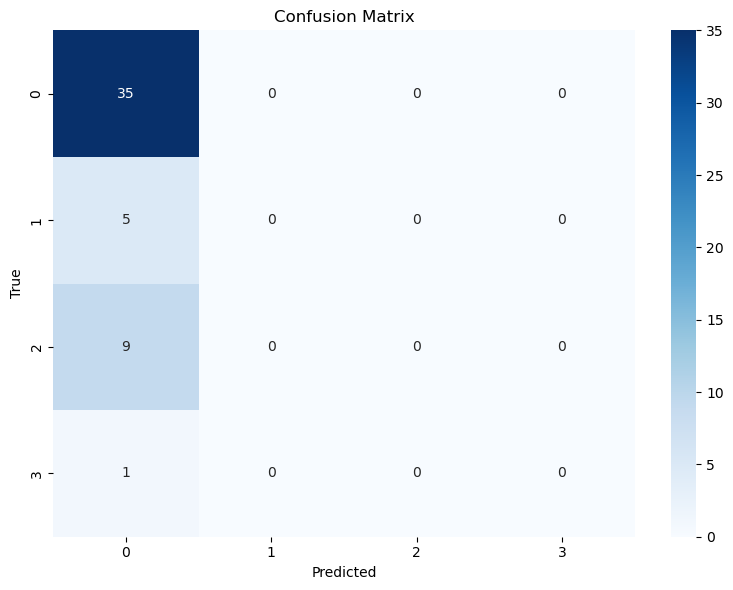

In [36]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

#### Notes
- stopping at 6 epochs because that's when the val_loss increases
- more dropout
- only add more images if necessary
- maybe need to adjust learning rate 

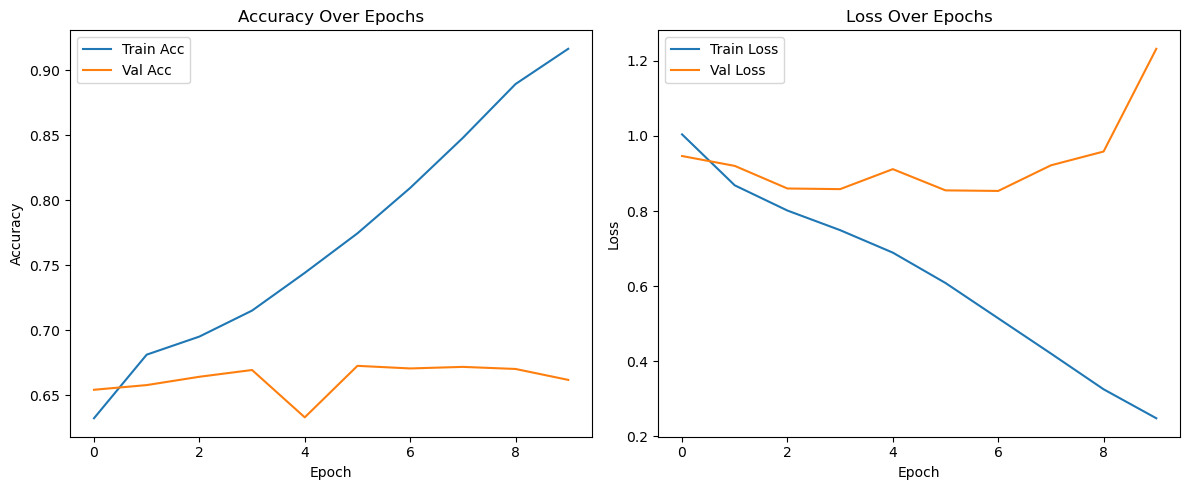

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
